In [1]:
from platform import python_version
print(python_version())
import pkg_resources
import sklearn
print(sklearn. __version__)
import pandas as pd
print(pd.__version__)
import pickle
import numpy as np

3.7.4
0.21.3
0.25.1


In [185]:
cgm_df = pd.read_csv("./CGMData.csv")
insulin_df = pd.read_csv("./InsulinData.csv")

In [3]:
print(cgm_df.info())
print(insulin_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55343 entries, 0 to 55342
Data columns (total 47 columns):
Index                                  55343 non-null int64
Date                                   55343 non-null object
Time                                   55343 non-null object
New Device Time                        0 non-null float64
BG Reading (mg/dL)                     0 non-null float64
Linked BG Meter ID                     0 non-null float64
Basal Rate (U/h)                       0 non-null float64
Temp Basal Amount                      0 non-null float64
Temp Basal Type                        0 non-null float64
Temp Basal Duration (h:mm:ss)          0 non-null float64
Bolus Type                             0 non-null float64
Bolus Volume Selected (U)              0 non-null float64
Bolus Volume Delivered (U)             0 non-null float64
Bolus Duration (h:mm:ss)               0 non-null float64
Prime Type                             0 non-null float64
Prime Volume 

In [234]:
# meal_inputs = insulin_df[insulin_df['BWZ Carb Input (grams)']].notna()
# insulin_df
# print(insulin_df['BWZ Carb Input (grams)'])
# print(insulin_df['BWZ Carb Input (grams)'].notna())
all_meals = list(insulin_df[insulin_df['BWZ Carb Input (grams)'].notna() & insulin_df['BWZ Carb Input (grams)'] != 0.0]['Time'][::-1])
all_indicies = insulin_df[insulin_df['BWZ Carb Input (grams)'].notna() & insulin_df['BWZ Carb Input (grams)'] != 0.0].index[::-1].values
# print(all_meals)
# print(len(all_indicies))
filtered = []
# filtered_meals = all_meals[all_meals['']]
for i in range(0, len(all_indicies)):
    index = all_indicies[i]
    add_index = True
    date_time = insulin_df.iloc[index][['Date', 'Time']].values
    date_time = pd.to_datetime(date_time[0] + " "+ date_time[1])
    while True:
        index -= 1
        row = insulin_df['BWZ Carb Input (grams)'].iloc[index]
        row_date_time = insulin_df[['Date', 'Time']].iloc[index].values
        row_date_time = pd.to_datetime(row_date_time[0] + " "+ row_date_time[1])
        if row_date_time > (date_time + pd.Timedelta(2, "h")) or index < 0:
            break
        if not np.isnan(row):
            add_index = False
            break
    if add_index:
        filtered.append(all_indicies[i])

print(len(filtered))
#559 X 30 Meal Data matrix


559


In [230]:
print(len(all_indicies))

747


In [236]:
# all_meals = insulin_df[insulin_df['BWZ Carb Input (grams)'].isna() & insulin_df['BWZ Carb Input (grams)'] != 0.0]['BWZ Carb Input (grams)']
# all_indicies = insulin_df[insulin_df['BWZ Carb Input (grams)'].isna() & insulin_df['BWZ Carb Input (grams)'] == 0.0].index[::-1].values

# print(all_indicies)
not_meals = []
index = filtered[0]
while True:
    add_list = True
    ignore = True
    if index < 0:
        break
    date_time = insulin_df.iloc[index][['Date', 'Time']].values
    date_time = pd.to_datetime(date_time[0] + " "+ date_time[1])
    #meal data
    while ignore:
        index -= 1
        row = insulin_df['BWZ Carb Input (grams)'].iloc[index]
        row_date_time = insulin_df[['Date', 'Time']].iloc[index].values
        row_date_time = pd.to_datetime(row_date_time[0] + " "+ row_date_time[1])
        if row_date_time > (date_time + pd.Timedelta(2, "h")) or index < 0:
            ignore = False
            break
        if not np.isnan(row):
            date_time = insulin_df.iloc[index][['Date', 'Time']].values
            date_time = pd.to_datetime(date_time[0] + " "+ date_time[1])
    original_index = index
    date_time = insulin_df.iloc[index][['Date', 'Time']].values
    date_time = pd.to_datetime(date_time[0] + " "+ date_time[1])
    while True:
        row = insulin_df['BWZ Carb Input (grams)'].iloc[index]
        row_date_time = insulin_df[['Date', 'Time']].iloc[index].values
        row_date_time = pd.to_datetime(row_date_time[0] + " "+ row_date_time[1])
        if row_date_time > (date_time + pd.Timedelta(2, "h")) or index < 0:
            break
        if not np.isnan(row):
            add_list = False
            break
        index -= 1
    if add_list:
        not_meals.append(original_index)        
    
print(len(not_meals))
#622


622


In [306]:
meals_M = []
count = 0
for i in filtered:
    date_time = insulin_df[['Date','Time']].iloc[i].values
    date_time = date_time[0] + " "+ date_time[1]
    date_time = pd.to_datetime(date_time)
#     print(date_time)
    date_data = cgm_df[(pd.to_datetime(cgm_df['Date']).dt.date == date_time.date())][["Date", "Time", "Sensor Glucose (mg/dL)"]]
#     print(date_data[["Date", "Time", "Sensor Glucose (mg/dL)"]])
    lower = date_data[(pd.to_datetime(date_data['Time']).dt.time >= date_time.time())]
    upper = date_data[(pd.to_datetime(date_data['Time']).dt.time <= (date_time + pd.Timedelta(5, "m")).time())]
    if len(lower) > 0 and len(upper) > 0:
        low = lower.iloc[-1]
        up = upper.iloc[0]
        if up.name == low.name:
            index = up.name
#             print(index)
#             print(list(cgm_df.iloc[index-24:index+7]['Time'][::-1]))
#             print(list(cgm_df.iloc[index-24:index+7]['Sensor Glucose (mg/dL)'][::-1]))
            meals_M.append(list(cgm_df.iloc[index-20:index+4]['Sensor Glucose (mg/dL)'][::-1]))

print(len(meals_M))

553


In [275]:
not_meals_M = []
for i in not_meals:
    date_time = insulin_df[['Date','Time']].iloc[i].values
    date_time = date_time[0] + " "+ date_time[1]
    date_time = pd.to_datetime(date_time)
    
    date_data = cgm_df[(pd.to_datetime(cgm_df['Date']).dt.date == date_time.date())][["Date", "Time", "Sensor Glucose (mg/dL)"]]

    lower = date_data[(pd.to_datetime(date_data['Time']).dt.time >= date_time.time())]
    upper = date_data[(pd.to_datetime(date_data['Time']).dt.time <= (date_time + pd.Timedelta(5, "m")).time())]
    if len(lower) > 0 and len(upper) > 0:
        low = lower.iloc[-1]
        up = upper.iloc[0]
        if up.name == low.name:
            index = up.name
            not_meals_M.append(list(cgm_df.iloc[index-23:index+1]['Sensor Glucose (mg/dL)'][::-1]))

print(len(not_meals_M))
    
    
#     print(cgm_df[(cgm_df['Date'] == date_time[0]) & (pd.to_datetime(cgm_df['Time'],format='%H:%M:%S').dt.time >= pd.to_datetime(date_time[1],format='%H:%M:%S').time())][['Time','Sensor Glucose (mg/dL)']])#[::-1][0:25])
  

612


In [307]:
print(meals_M[0])
print(len(meals_M[0]))

[71.0, 81.0, 102.0, 131.0, 140.0, 147.0, 153.0, 159.0, 163.0, 159.0, 153.0, 151.0, 155.0, 163.0, 164.0, nan, 166.0, 168.0, 164.0, 169.0, 178.0, 184.0, 190.0, 195.0]
24


In [241]:
print(not_meals_M[0])
print(len(not_meals_M[0]))

[73.0, 70.0, 65.0, 62.0, 59.0, 58.0, 63.0, 71.0, 81.0, 86.0, 81.0, 75.0, 71.0, 64.0, 57.0, 50.0, 45.0, 44.0, 43.0, 45.0, 46.0, 47.0, 48.0, 51.0]
24


In [356]:
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

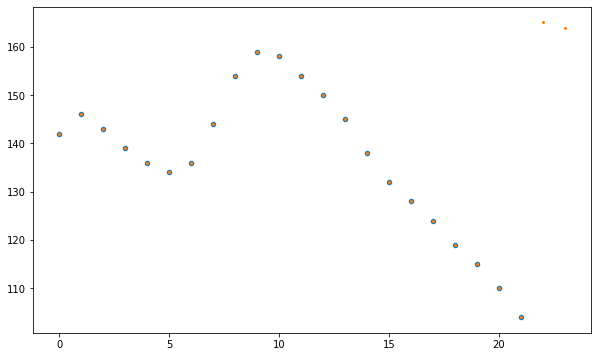

In [376]:
# remove = []
# for i in range(0,len(meals_M[0])):
#     if np.isnan(i):
#         remove.append(i)
# for i in remove:
#     meals_M[0].pop(i)
    
# X = np.arange(0, len(meals_M[0])).reshape(-1, 1)
# y = meals_M[0]
# model = models[-1]
# y_pred = model.predict(remove[0])
# plt.plot(X, y_pred, linewidth=2)
# plt.scatter(X, y, s=20, marker='o', label='training points')
# plt.show()


# X = np.arange(0, 24).reshape(-1, 1)
# y = meals_M[0]
# models = []
# for count, degree in enumerate([4, 5, 6]):
#     model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=0.001))
#     model.fit(X, y)
#     models.append(model)
#     y_pred = model.predict(X)
#     plt.plot(X, y_pred, linewidth=2, label='degree %d' % degree)
# plt.legend(loc='upper left')
# plt.scatter(X, y, s=20, marker='o', label='training points')
# plt.show()

x = np.arange(0, 24)
plt.figure(figsize=(10,6))
plt.scatter(x, meals_M[470], s=20)
plt.scatter(x, new[470], s=4)
plt.show()

In [366]:
# print(meals_M)
X = meals_M

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
new = imp.fit_transform(X)
#new = imp.transform(X)
# print(imp.transform(X))
print(new)


[[ 71.  81. 102. ... 184. 190. 195.]
 [268. 259. 255. ... 267. 267. 274.]
 [ 40.  60.  71. ...  72.  70.  67.]
 ...
 [104. 123. 132. ... 162. 189. 201.]
 [ 60.  51.  52. ...  80.  84.  86.]
 [151. 154. 153. ... 184. 178. 180.]]


In [365]:
print(meals_M[0])
print(new[0])

[71.0, 81.0, 102.0, 131.0, 140.0, 147.0, 153.0, 159.0, 163.0, 159.0, 153.0, 151.0, 155.0, 163.0, 164.0, nan, 166.0, 168.0, 164.0, 169.0, 178.0, 184.0, 190.0, 195.0]
[ 71.          81.         102.         131.         140.
 147.         153.         159.         163.         159.
 153.         151.         155.         163.         164.
 176.43265306 166.         168.         164.         169.
 178.         184.         190.         195.        ]


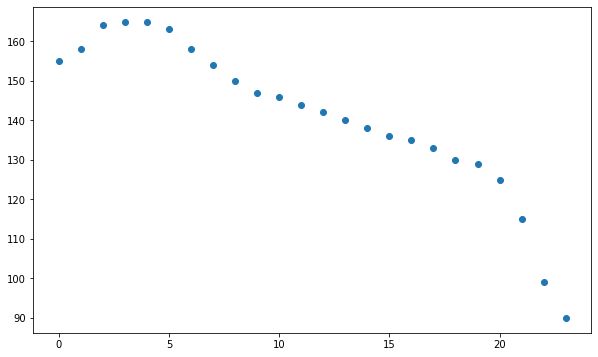

In [303]:
x = np.arange(0, 24)
plt.figure(figsize=(10,6))
plt.scatter(x, not_meals_M[122])
plt.show()

To do: 
* interpolate data
* (make object and get data from second patient)

* Feature extract
* Train model and save to pickle file (k fold)

* Make test.py

In [374]:
remove = []
count = 0
for i in range(0,len(meals_M)):
    if np.isnan(meals_M[i]).any():
        if np.count_nonzero(np.isnan(meals_M[i])) > 10:
            pass
        remove.append(i)
        count += 1
print(f"{count} dirty")
print(f"{len(remove)} to remove")
print(len(meals_M))
print(remove)

60 dirty
60 to remove
498
[0, 12, 13, 40, 66, 70, 71, 73, 88, 90, 102, 108, 129, 164, 165, 177, 179, 192, 193, 194, 198, 211, 220, 228, 233, 235, 237, 238, 239, 264, 271, 273, 294, 298, 305, 307, 308, 328, 329, 330, 345, 346, 352, 353, 356, 366, 383, 395, 397, 401, 418, 421, 453, 454, 461, 470, 475, 484, 487, 490]


In [310]:
for i in remove[::-1]:
    meals_M.pop(i)
print(len(meals_M))

498


In [311]:
remove = []
count = 0
for i in range(0,len(not_meals_M)):
    if np.isnan(not_meals_M[i]).any():
        if np.count_nonzero(np.isnan(not_meals_M[i])) > 10:
            remove.append(i)
        count += 1
print(f"{count} dirty")
print(f"{len(remove)} to remove")
print(len(not_meals_M))

56 dirty
0 to remove
580


In [290]:
for i in remove[::-1]:
    not_meals_M.pop(i)
print(len(not_meals_M))

580


In [381]:
class create_matricies:
    def __init__(self):
        self.cgm_1 = pd.read_csv("./CGMData.csv")
        self.insulin_1 = pd.read_csv("./InsulinData.csv")
        self.cgm_2 = pd.read_csv("./CGM_patient2.csv")
        self.insulin_2 = pd.read_csv("./Insulin_patient2.csv")

    #Get all meal indicies
    def insulin_scrape(self, insulin_df):
        all_indicies = insulin_df[insulin_df['BWZ Carb Input (grams)'].notna() & insulin_df['BWZ Carb Input (grams)'] != 0.0].index[::-1].values
        filtered = []
        for i in range(0, len(all_indicies)):
            index = all_indicies[i]
            add_index = True
            date_time = insulin_df.iloc[index][['Date', 'Time']].values
            date_time = pd.to_datetime(date_time[0] + " "+ date_time[1])
            while True:
                index -= 1
                row = insulin_df['BWZ Carb Input (grams)'].iloc[index]
                row_date_time = insulin_df[['Date', 'Time']].iloc[index].values
                row_date_time = pd.to_datetime(row_date_time[0] + " "+ row_date_time[1])
                if row_date_time > (date_time + pd.Timedelta(2, "h")) or index < 0:
                    break
                if not np.isnan(row):
                    add_index = False
                    break
            if add_index:
                filtered.append(all_indicies[i])
        return filtered

    #Get all not meal indicies
    def insulin_not_meals(self, insulin_df):
        filtered = self.insulin_scrape(insulin_df)
        not_meals = []
        index = filtered[0]
        while True:
            add_list = True
            ignore = True
            if index < 0:
                break
            date_time = insulin_df.iloc[index][['Date', 'Time']].values
            date_time = pd.to_datetime(date_time[0] + " "+ date_time[1])
            #meal data
            while ignore:
                index -= 1
                row = insulin_df['BWZ Carb Input (grams)'].iloc[index]
                row_date_time = insulin_df[['Date', 'Time']].iloc[index].values
                row_date_time = pd.to_datetime(row_date_time[0] + " "+ row_date_time[1])
                if row_date_time > (date_time + pd.Timedelta(2, "h")) or index < 0:
                    ignore = False
                    break
                if not np.isnan(row):
                    date_time = insulin_df.iloc[index][['Date', 'Time']].values
                    date_time = pd.to_datetime(date_time[0] + " "+ date_time[1])
            original_index = index
            date_time = insulin_df.iloc[index][['Date', 'Time']].values
            date_time = pd.to_datetime(date_time[0] + " "+ date_time[1])
            #Not meal data
            while True:
                row = insulin_df['BWZ Carb Input (grams)'].iloc[index]
                row_date_time = insulin_df[['Date', 'Time']].iloc[index].values
                row_date_time = pd.to_datetime(row_date_time[0] + " "+ row_date_time[1])
                if row_date_time > (date_time + pd.Timedelta(2, "h")) or index < 0:
                    break
                if not np.isnan(row):
                    add_list = False
                    break
                index -= 1
            if add_list:
                not_meals.append(original_index)  
        return not_meals

    #Create Data Matrix
    def create_matrix(self, insulin_df, cgm_df, meal):
        matrix = []
        if meal:
            filtered = self.insulin_scrape(insulin_df)
        else:
            filtered = self.insulin_not_meals(insulin_df)
        for i in filtered:
            date_time = insulin_df[['Date','Time']].iloc[i].values
            date_time = date_time[0] + " "+ date_time[1]
            date_time = pd.to_datetime(date_time)
            date_data = cgm_df[(pd.to_datetime(cgm_df['Date']).dt.date == date_time.date())][["Date", "Time", "Sensor Glucose (mg/dL)"]]
            lower = date_data[(pd.to_datetime(date_data['Time']).dt.time >= date_time.time())]
            upper = date_data[(pd.to_datetime(date_data['Time']).dt.time <= (date_time + pd.Timedelta(5, "m")).time())]
            if len(lower) > 0 and len(upper) > 0:
                low = lower.iloc[-1]
                up = upper.iloc[0]
                if up.name == low.name:
                    index = up.name
                    if meal:
                        matrix.append(list(cgm_df.iloc[index-20:index+4]['Sensor Glucose (mg/dL)'][::-1]))
                    else:
                        matrix.append(list(cgm_df.iloc[index-23:index+1]['Sensor Glucose (mg/dL)'][::-1]))
        return matrix

                        
    #Clean data (interpolate or remove as needed)
    def clean(self, matrix, meal):
        remove = []
        for i in range(0,len(matrix)):
            if np.isnan(matrix[i]).any():
                remove.append(i)
#                 if np.count_nonzero(np.isnan(matrix[i])) > 10:
#                     remove.append(i)
#                 else:
#                     if meal:
#                         #interpolate 1 way
#                         pass
#                     else:
#                         #interpolate another way
#                         pass

        for i in remove[::-1]:
            matrix.pop(i)
        
        return matrix
    
    #Combine Matricies
    def combine(self, m1, m2):
#         for row in m2:
#             m1.append(row)
        return np.concatenate((m1,m2))
    
    #Do everything
    def start(self):
        print("Making Matricies")
        p1meal = self.create_matrix(self.insulin_1, self.cgm_1, meal=True)
        p1not = self.create_matrix(self.insulin_1, self.cgm_1, meal=False)
        print("Patient 1 Done")
        p2meal = self.create_matrix(self.insulin_2, self.cgm_2, meal=True)
        p2not = self.create_matrix(self.insulin_2, self.cgm_2, meal=False)
        print("Patient 2 Done")
        print("Merging and Cleaning")
        meal_matrix = self.combine(self.clean(p1meal, meal=True), self.clean(p2meal, meal=True))
        not_meal_matrix = self.combine(self.clean(p1not, meal=False), self.clean(p2not, meal=False))
        print("Complete")
        return meal_matrix, not_meal_matrix


# Feature Extraction

In [382]:
cm = create_matricies()
m, n = cm.start()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (13,43) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Making Matricies
Patient 1 Done
Patient 2 Done
Merging and Cleaning
Complete


In [429]:
print(m)
print(len(m))
m_labels = np.ones((len(m),1))
print(n)
print(len(n))
n_labels = np.zeros((len(n),1))

[[268. 259. 255. ... 267. 267. 274.]
 [ 40.  60.  71. ...  72.  70.  67.]
 [200. 199. 201. ... 213. 210. 210.]
 ...
 [153. 152. 150. ... 147. 147. 153.]
 [207. 210. 216. ... 129. 130. 132.]
 [147. 146. 147. ... 133. 139. 165.]]
718
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


In [512]:
class feature_extract:
    def __init__(self, df):
        self.df = df
    
    #Time difference between min and peak times
    def feature_1(self, values):
        mini = min(values[0:7])
        maxi = max(values[7:])
        return np.where(values == maxi)[0][0] - np.where(values == mini)[0][0]
    
    #CGM difference between min and peak values
    def feature_2(self, values):
        mini = min(values[0:7])
        maxi = max(values[7:])
        return (maxi - mini) / mini
    
    #Differental value from min to peak values
    def feature_3(self, values):
        rise = self.feature_2(values)
        run = self.feature_1(values)
        if run == 0:
            run = 1
        return rise / run
    
    #Create Feature Matrix
    def extract(self):
        matrix = np.ndarray(shape=(0,3), dtype=np.intc)
        for row in self.df:
            matrix = np.vstack([matrix, np.array([self.feature_1(row), self.feature_2(row), self.feature_3(row)])])
        return matrix

In [513]:
m_f = feature_extract(m)
meal_features = m_f.extract()
print(meal_features)

[[ 1.20000000e+01  2.59090909e-01  2.15909091e-02]
 [ 1.00000000e+01  2.30000000e+00  2.30000000e-01]
 [ 1.40000000e+01  1.80327869e-01  1.28805621e-02]
 ...
 [-6.00000000e+00  1.59090909e-01 -2.65151515e-02]
 [ 7.00000000e+00  2.70531401e-01  3.86473430e-02]
 [ 5.00000000e+00  1.30136986e-01  2.60273973e-02]]


In [514]:
n_f = feature_extract(n)
not_meal_features = n_f.extract()
print(not_meal_features)

[[ 4.00000000e+00  4.82758621e-01  1.20689655e-01]
 [ 1.00000000e+00 -7.60869565e-02 -7.60869565e-02]
 [ 1.70000000e+01  4.59770115e-01  2.70453009e-02]
 ...
 [ 2.10000000e+01  8.45454545e-01  4.02597403e-02]
 [ 1.20000000e+01  6.07142857e-02  5.05952381e-03]
 [ 1.90000000e+01  1.01075269e+00  5.31975099e-02]]


In [515]:
meal_features_labels = np.concatenate((meal_features, m_labels), axis=1)
print(meal_features_labels)

[[ 1.20000000e+01  2.59090909e-01  2.15909091e-02  1.00000000e+00]
 [ 1.00000000e+01  2.30000000e+00  2.30000000e-01  1.00000000e+00]
 [ 1.40000000e+01  1.80327869e-01  1.28805621e-02  1.00000000e+00]
 ...
 [-6.00000000e+00  1.59090909e-01 -2.65151515e-02  1.00000000e+00]
 [ 7.00000000e+00  2.70531401e-01  3.86473430e-02  1.00000000e+00]
 [ 5.00000000e+00  1.30136986e-01  2.60273973e-02  1.00000000e+00]]


In [516]:
not_meal_features_labels = np.concatenate((not_meal_features, n_labels), axis=1)
print(not_meal_features_labels)

[[ 4.00000000e+00  4.82758621e-01  1.20689655e-01  0.00000000e+00]
 [ 1.00000000e+00 -7.60869565e-02 -7.60869565e-02  0.00000000e+00]
 [ 1.70000000e+01  4.59770115e-01  2.70453009e-02  0.00000000e+00]
 ...
 [ 2.10000000e+01  8.45454545e-01  4.02597403e-02  0.00000000e+00]
 [ 1.20000000e+01  6.07142857e-02  5.05952381e-03  0.00000000e+00]
 [ 1.90000000e+01  1.01075269e+00  5.31975099e-02  0.00000000e+00]]


In [517]:
data_matrix = np.concatenate((meal_features_labels, not_meal_features_labels))
print(data_matrix)

[[1.20000000e+01 2.59090909e-01 2.15909091e-02 1.00000000e+00]
 [1.00000000e+01 2.30000000e+00 2.30000000e-01 1.00000000e+00]
 [1.40000000e+01 1.80327869e-01 1.28805621e-02 1.00000000e+00]
 ...
 [2.10000000e+01 8.45454545e-01 4.02597403e-02 0.00000000e+00]
 [1.20000000e+01 6.07142857e-02 5.05952381e-03 0.00000000e+00]
 [1.90000000e+01 1.01075269e+00 5.31975099e-02 0.00000000e+00]]


In [518]:
df = pd.DataFrame(data=data_matrix, columns=['f1', 'f2', 'f3', 'meal'])
print(df)

        f1        f2        f3  meal
0     12.0  0.259091  0.021591   1.0
1     10.0  2.300000  0.230000   1.0
2     14.0  0.180328  0.012881   1.0
3     11.0  0.745902  0.067809   1.0
4     23.0  2.452830  0.106645   1.0
...    ...       ...       ...   ...
1531  12.0  0.120000  0.010000   0.0
1532  16.0  0.119718  0.007482   0.0
1533  21.0  0.845455  0.040260   0.0
1534  12.0  0.060714  0.005060   0.0
1535  19.0  1.010753  0.053198   0.0

[1536 rows x 4 columns]


In [519]:
np.random.seed(42)

In [520]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [521]:
X_train = train_set[['f1', 'f2', 'f3']].copy()
y_train = train_set['meal'].copy()

X_test = test_set[['f1', 'f2', 'f3']].copy()
y_test = test_set['meal'].copy()

In [522]:
print(X_test)

        f1        f2        f3
1159  18.0  0.122222  0.006790
76     1.0 -0.031142 -0.031142
316    6.0  0.522523  0.087087
1040  19.0  1.013158  0.053324
1357   1.0 -0.040936 -0.040936
...    ...       ...       ...
846    8.0  0.020833  0.002604
1518  12.0  0.185930  0.015494
233    7.0  1.153846  0.164835
976    7.0  1.232558  0.176080
196   13.0  1.340000  0.103077

[308 rows x 3 columns]


# Train Model

In [523]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier


In [524]:
folds = 6
clf_g = DecisionTreeClassifier(random_state=42)
print(f"DT(gini): {max(cross_val_score(clf_g, X_train, y_train, cv=folds, scoring='accuracy'))}")
clf_e = DecisionTreeClassifier(criterion="entropy", random_state=42)
print(f"DT(entropy): {max(cross_val_score(clf_e, X_train, y_train, cv=folds, scoring='accuracy'))}")

# kernel = 1.0 * RBF(1.0)
# gpc = GaussianProcessClassifier(kernel=kernel,random_state=42)
# print(f"Gauss: {max(cross_val_score(gpc, X_train, y_train, cv=folds, scoring='accuracy'))}")

svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
print(f"SVM: {max(cross_val_score(svm_clf, X_train, y_train, cv=folds, scoring='accuracy'))}")
      
mlp_clf = MLPClassifier(random_state=42, max_iter=300)
print(f"MLP: {max(cross_val_score(mlp_clf, X_train, y_train, cv=folds, scoring='accuracy'))}")


DT(gini): 0.6502463054187192
DT(entropy): 0.6634146341463415
SVM: 0.7317073170731707
MLP: 0.7121951219512195


# Evaluate

In [525]:
from sklearn.model_selection import cross_val_score

cross_val_score(svm_clf, X_train, y_train, cv=folds, scoring="accuracy")


array([0.73170732, 0.65365854, 0.68780488, 0.65853659, 0.67804878,
       0.67487685])

In [526]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv=folds)

In [527]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))


0.7093821510297483
0.5391304347826087


In [528]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred)

0.6126482213438734

In [529]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(svm_clf, X_train, y_train, cv=6, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [530]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

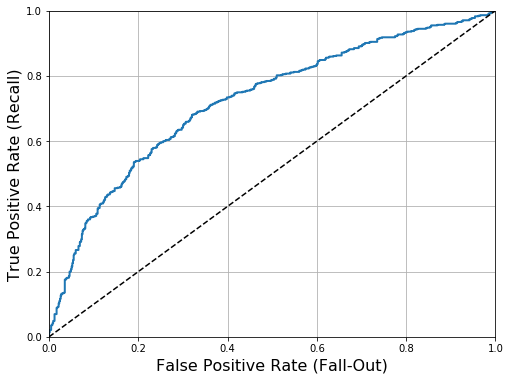

In [531]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)

#save_fig("roc_curve_plot")                         # Not shown
plt.show()

In [532]:
svm_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='auto',
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [533]:
from sklearn.metrics import accuracy_score

In [536]:
y_test_pred = svm_clf.predict(X_test)
print(y_test_pred)

[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.]


In [535]:
accuracy_score(y_test, y_test_pred)

0.6753246753246753

# Save Model to File

In [537]:
filename = 'final_model.sav'
pickle.dump(svm_clf, open(filename, 'wb'))

# Test.py

In [538]:
from platform import python_version
print(python_version())
import pkg_resources
import sklearn
print(sklearn. __version__)
import pandas as pd
print(pd.__version__)
import pickle
import numpy as np

3.7.4
0.21.3
0.25.1


In [544]:
print(m[0])
f = open('./test.csv', 'w')
writer = csv.writer(f)
writer.writerow(m[0])
f.close()

[268. 259. 255. 248. 241. 231. 220. 222. 222. 222. 223. 224. 228. 233.
 243. 256. 262. 270. 277. 274. 269. 267. 267. 274.]


In [540]:
filename = 'final_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [565]:
test_df = pd.read_csv("./test.csv", header=None)

matrix = np.ndarray(shape=(0,24), dtype=np.intc)
for i in range(0,len(test_df)):
    matrix = np.vstack([matrix, np.array(list(test_df.loc[i]))])

m_f = feature_extract(matrix)
features_df = m_f.extract()

y_preds = loaded_model.predict(features_df)
print(y_preds)
f = open('./Results.csv', 'w')
writer = csv.writer(f)
for i in y_preds:
    writer.writerow([i])
f.close()

[0.]


In [ ]:
test_df = pd.read_csv("./test.csv", header=None)

In [ ]:
y_preds = []
for ind in test_df.index:
    y_preds.append(loaded_model.predict(test_df[ind]))

In [543]:
import csv

In [179]:
f = open('./Results.csv', 'w')
writer = csv.writer(f)
for i in y_preds:
    writer.writerow(i)
f.close()